In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import shap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Loading

In [20]:
# File paths
train_file = "cs-training.csv"
test_file = "cs-test.csv"

# Load datasets
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Display basic info and first few rows
train_info = train_df.info()
test_info = test_df.info()
train_head = train_df.head()
test_head = test_df.head()

train_info, test_info, train_head, test_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

(None,
 None,
    Unnamed: 0  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
 0           1                 1                              0.766127   45   
 1           2                 0                              0.957151   40   
 2           3                 0                              0.658180   38   
 3           4                 0                              0.233810   30   
 4           5                 0                              0.907239   49   
 
    NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
 0                                     2   0.802982         9120.0   
 1                                     0   0.121876         2600.0   
 2                                     1   0.085113         3042.0   
 3                                     0   0.036050         3300.0   
 4                                     1   0.024926        63588.0   
 
    NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
 0                      

# Data Preprocessing

In [21]:
print('Train Data Size : ',train_df.shape)

Train Data Size :  (150000, 12)


In [22]:
train_df.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

## Handling missing values

In [23]:
train_df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [24]:
test_df.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In [25]:
# Handling missing values (Filling with median for `MonthlyIncome` and mode for `NumberOfDependents`)

# For the train dataset
median_income_train = train_df["MonthlyIncome"].median()
train_df.loc[:, "MonthlyIncome"] = train_df["MonthlyIncome"].fillna(median_income_train)

mode_dependents_train = train_df["NumberOfDependents"].mode()[0]
train_df.loc[:, "NumberOfDependents"] = train_df["NumberOfDependents"].fillna(mode_dependents_train)

# For the test dataset
median_income_test = test_df["MonthlyIncome"].median()
test_df.loc[:, "MonthlyIncome"] = test_df["MonthlyIncome"].fillna(median_income_test)

mode_dependents_test = test_df["NumberOfDependents"].mode()[0]
test_df.loc[:, "NumberOfDependents"] = test_df["NumberOfDependents"].fillna(mode_dependents_test)


In [26]:
if 'Unnamed: 0' in train_df.columns:
    train_df = train_df.drop(columns=['Unnamed: 0'])
if 'Unnamed: 0' in test_df.columns:
    test_df = test_df.drop(columns=['Unnamed: 0'])

In [27]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    150000 non-null  float64
dtype

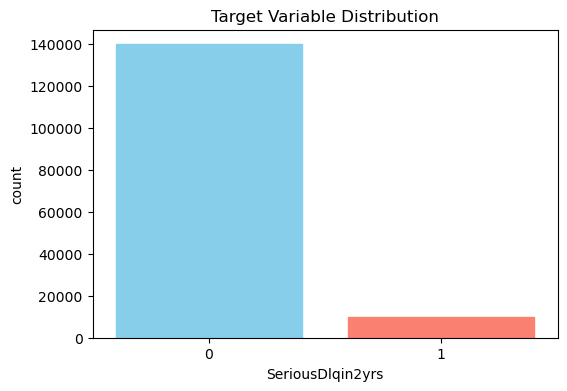

In [28]:
# Target variable distribution
plt.figure(figsize=(6, 4))

# Create the countplot
ax = sns.countplot(x="SeriousDlqin2yrs", data=train_df)

# Set different colors manually for each bar
colors = ["skyblue", "salmon"]  # Define colors for each category
for i, bar in enumerate(ax.patches):  
    bar.set_color(colors[i])  # Assign color to each bar

plt.title("Target Variable Distribution")
plt.show()

In [29]:
test_df.isnull().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
dtype: int64

In [30]:
train_df.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

## Encoding

In [31]:
# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns for train data:", categorical_cols)
# Identify categorical columns
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns for test data:", categorical_cols)

Categorical Columns for train data: []
Categorical Columns for test data: []


## Feature Scaling

In [32]:
# Identify numerical columns (excluding the target variable)
numeric_features = train_df.select_dtypes(include=['number']).columns.tolist()
if "SeriousDlqin2yrs" in numeric_features:
    numeric_features.remove("SeriousDlqin2yrs")  # Exclude target from scaling

# Apply MinMax scaling to numerical features
scaler = MinMaxScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Check final dataset
print(train_df.head())
print(test_df.head())

   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines       age  \
0                 1                              0.000015  0.412844   
1                 0                              0.000019  0.366972   
2                 0                              0.000013  0.348624   
3                 0                              0.000005  0.275229   
4                 0                              0.000018  0.449541   

   NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
0                              0.020408  2.435759e-06       0.003031   
1                              0.000000  3.696982e-07       0.000864   
2                              0.010204  2.581822e-07       0.001011   
3                              0.000000  1.093528e-07       0.001097   
4                              0.010204  7.560939e-08       0.021134   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                         0.224138                 0.000000   
1             

# EDA

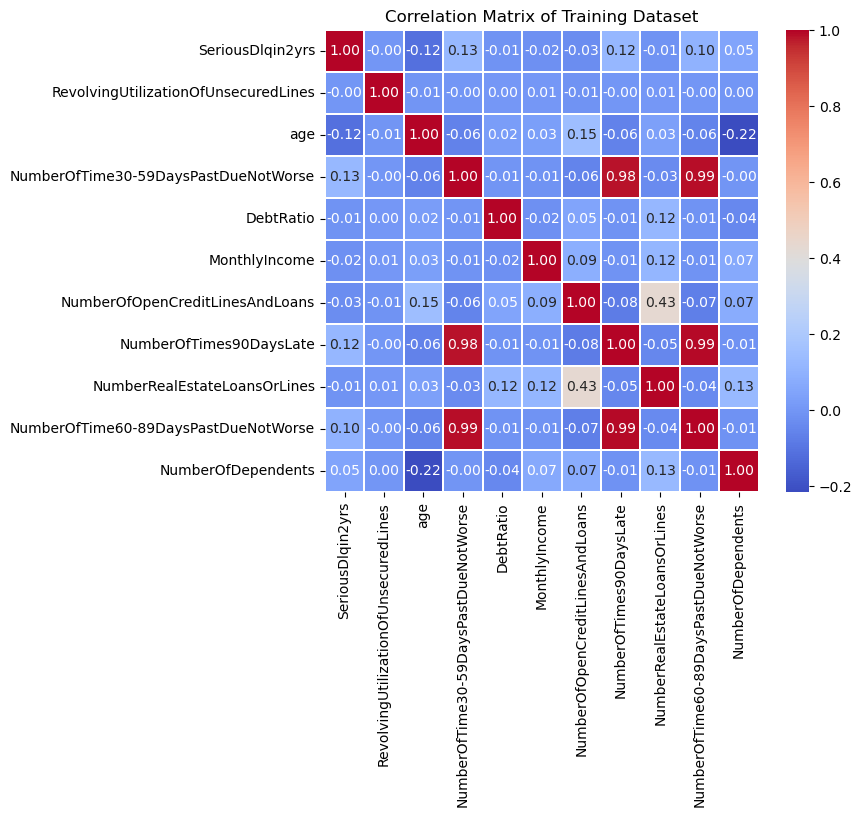

In [33]:
# Correlation Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.1)
plt.title("Correlation Matrix of Training Dataset")
plt.show()

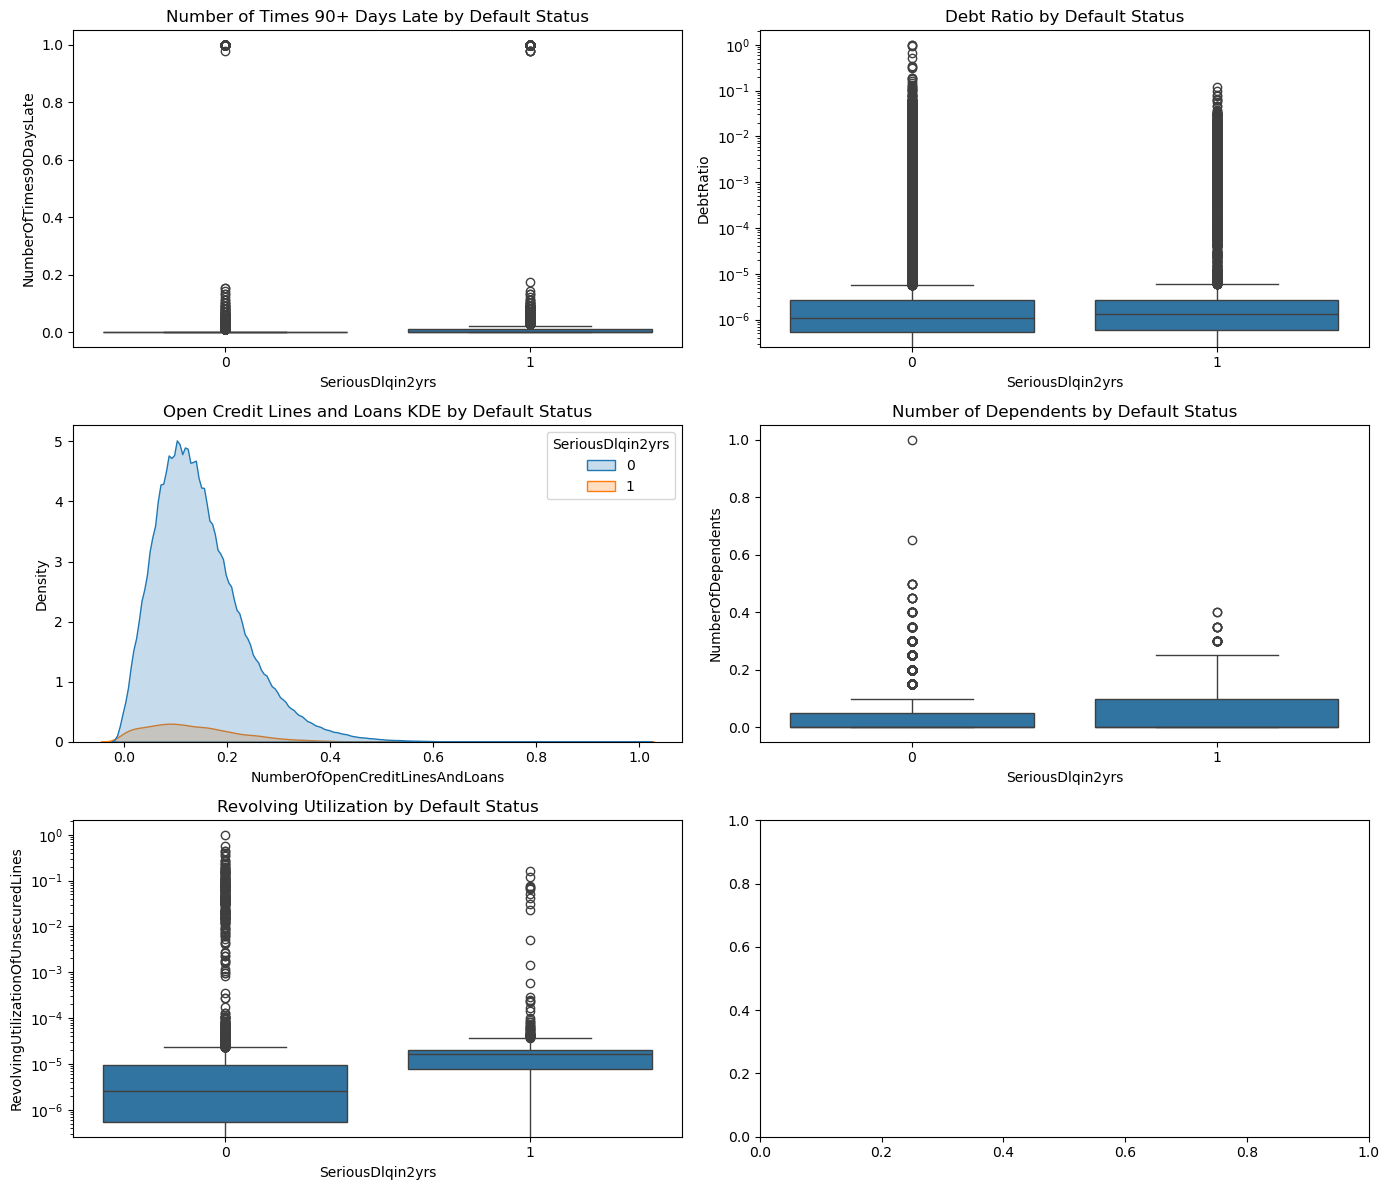

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Credit History Bias
sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTimes90DaysLate", data=train_df, ax=axes[0,0])
axes[0,0].set_title("Number of Times 90+ Days Late by Default Status")

# Debt Ratio Bias
sns.boxplot(x="SeriousDlqin2yrs", y="DebtRatio", data=train_df, ax=axes[0,1])
axes[0,1].set_yscale("log")
axes[0,1].set_title("Debt Ratio by Default Status")

# Credit Line Bias
sns.kdeplot(data=train_df, x="NumberOfOpenCreditLinesAndLoans", hue="SeriousDlqin2yrs", fill=True, ax=axes[1,0])
axes[1,0].set_title("Open Credit Lines and Loans KDE by Default Status")

# Dependents Bias
sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfDependents", data=train_df.dropna(), ax=axes[1,1])
axes[1,1].set_title("Number of Dependents by Default Status")

# Revolving Utilization Bias
sns.boxplot(x="SeriousDlqin2yrs", y="RevolvingUtilizationOfUnsecuredLines", data=train_df, ax=axes[2,0])
axes[2,0].set_title("Revolving Utilization by Default Status")
axes[2,0].set_yscale("log")

plt.tight_layout()
plt.show()

In [35]:
# Statistical Tests
# Credit History Impact
t_stat, p_val = stats.ttest_ind(
    train_df[train_df['SeriousDlqin2yrs'] == 1]["NumberOfTimes90DaysLate"],
    train_df[train_df['SeriousDlqin2yrs'] == 0]["NumberOfTimes90DaysLate"],
    equal_var=False
)
print(f"Credit History Impact: t-stat={t_stat:.2f}, p-value={p_val:.5f}")

# Debt Ratio Impact
t_stat, p_val = stats.ttest_ind(
    train_df[train_df['SeriousDlqin2yrs'] == 1]["DebtRatio"],
    train_df[train_df['SeriousDlqin2yrs'] == 0]["DebtRatio"],
    equal_var=False
)
print(f"Debt Ratio Impact: t-stat={t_stat:.2f}, p-value={p_val:.5f}")

# Dependents Impact
t_stat, p_val = stats.ttest_ind(
    train_df[train_df['SeriousDlqin2yrs'] == 1]["NumberOfDependents"].dropna(),
    train_df[train_df['SeriousDlqin2yrs'] == 0]["NumberOfDependents"].dropna(),
    equal_var=False
)
print(f"Dependents Impact: t-stat={t_stat:.2f}, p-value={p_val:.5f}")

Credit History Impact: t-stat=16.62, p-value=0.00000
Debt Ratio Impact: t-stat=-4.57, p-value=0.00000
Dependents Impact: t-stat=16.64, p-value=0.00000


# Model Development

## Model Training

In [36]:
# Define features and target variable
X = train_df.drop(columns=["SeriousDlqin2yrs"])
y = train_df["SeriousDlqin2yrs"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardizing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"{name} Model Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)


Logistic Regression Model Performance:
Accuracy: 0.934
ROC-AUC Score: 0.7143274515978317
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     27995
           1       0.58      0.04      0.08      2005

    accuracy                           0.93     30000
   macro avg       0.76      0.52      0.52     30000
weighted avg       0.91      0.93      0.91     30000

--------------------------------------------------
Random Forest Model Performance:
Accuracy: 0.9363
ROC-AUC Score: 0.8409741497301576
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.57      0.19      0.28      2005

    accuracy                           0.94     30000
   macro avg       0.76      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000

--------------------------------------------------
Gradient Boosting Model

## Optimize hyperparameters

In [37]:
# Define hyperparameter distributions
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    }
}

# Perform hyperparameter tuning for each model
best_models = {}
for name, model in models.items():
    print(f"Optimizing {name}...")
    
    if name == "Logistic Regression":
        search = GridSearchCV(model, param_grids[name], scoring='roc_auc', cv=3, n_jobs=-1)
        search.fit(X_train_scaled, y_train)
    else:
        search = RandomizedSearchCV(model, param_grids[name], scoring='roc_auc', cv=3, n_iter=5, random_state=42, n_jobs=-1)
        search.fit(X_train, y_train)
    
    best_models[name] = search.best_estimator_
    
    print(f"Best Parameters for {name}: {search.best_params_}")
    
    y_pred = search.best_estimator_.predict(X_test_scaled if name == "Logistic Regression" else X_test)
    y_prob = search.best_estimator_.predict_proba(X_test_scaled if name == "Logistic Regression" else X_test)[:, 1]
    
    print(f"{name} Model Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

Optimizing Logistic Regression...
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Logistic Regression Model Performance:
Accuracy: 0.9336666666666666
ROC-AUC Score: 0.7153882573437811
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     27995
           1       0.56      0.03      0.06      2005

    accuracy                           0.93     30000
   macro avg       0.75      0.52      0.52     30000
weighted avg       0.91      0.93      0.91     30000

--------------------------------------------------
Optimizing Random Forest...
Best Parameters for Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 10}
Random Forest Model Performance:
Accuracy: 0.9368666666666666
ROC-AUC Score: 0.8677647549281823
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.60      0.16   

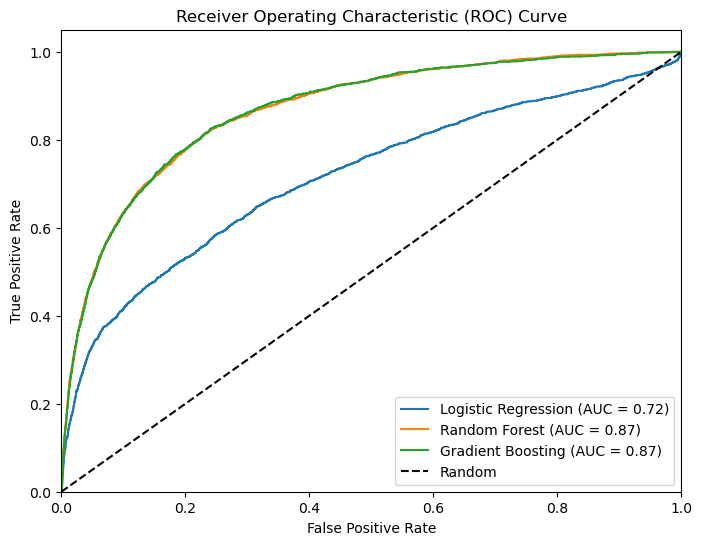

In [40]:
# Plot combined ROC Curve for all models
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    if name == "Logistic Regression":
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

Explaining Logistic Regression with SHAP...


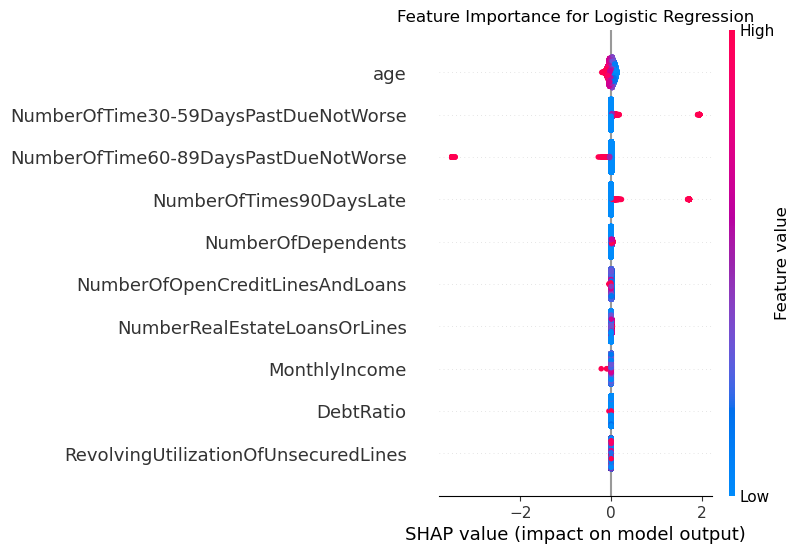

Explaining Random Forest with SHAP...


100%|===================| 59952/60000 [10:49<00:00]        

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.691943, while the model output was 0.676511. If this difference is acceptable you can set check_additivity=False to disable this check.

In [44]:
# Explainability using SHAP
for name, model in best_models.items():
    print(f"Explaining {name} with SHAP...")
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)
    
    # SHAP summary plot without check_additivity
    plt.figure()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"Feature Importance for {name}")
    plt.show()

In [46]:
# Generate predictions for different input scenarios with complete feature set
def generate_predictions(model, scenario):
    df = pd.DataFrame([scenario], columns=X.columns)
    return model.predict_proba(df)[:, 1][0]

# Define complete scenarios (include all features)
scenarios = [
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.9,
        "age": 30,
        "NumberOfTime30-59DaysPastDueNotWorse": 0,
        "DebtRatio": 0.6,
        "MonthlyIncome": 1500,
        "NumberOfOpenCreditLinesAndLoans": 2,
        "NumberOfTimes90DaysLate": 0,
        "NumberRealEstateLoansOrLines": 1,
        "NumberOfTime60-89DaysPastDueNotWorse": 0,
        "NumberOfDependents": 1
    },
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.9,
        "age": 30,
        "NumberOfTime30-59DaysPastDueNotWorse": 0,
        "DebtRatio": 0.6,
        "MonthlyIncome": 6000,
        "NumberOfOpenCreditLinesAndLoans": 2,
        "NumberOfTimes90DaysLate": 0,
        "NumberRealEstateLoansOrLines": 1,
        "NumberOfTime60-89DaysPastDueNotWorse": 0,
        "NumberOfDependents": 1
    },
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.5,
        "age": 40,
        "NumberOfTime30-59DaysPastDueNotWorse": 1,
        "DebtRatio": 0.8,
        "MonthlyIncome": 4000,
        "NumberOfOpenCreditLinesAndLoans": 3,
        "NumberOfTimes90DaysLate": 1,
        "NumberRealEstateLoansOrLines": 0,
        "NumberOfTime60-89DaysPastDueNotWorse": 1,
        "NumberOfDependents": 2
    },
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.5,
        "age": 40,
        "NumberOfTime30-59DaysPastDueNotWorse": 1,
        "DebtRatio": 0.2,
        "MonthlyIncome": 4000,
        "NumberOfOpenCreditLinesAndLoans": 3,
        "NumberOfTimes90DaysLate": 1,
        "NumberRealEstateLoansOrLines": 0,
        "NumberOfTime60-89DaysPastDueNotWorse": 1,
        "NumberOfDependents": 2
    },
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.4,
        "age": 25,
        "NumberOfTime30-59DaysPastDueNotWorse": 0,
        "DebtRatio": 0.4,
        "MonthlyIncome": 5000,
        "NumberOfOpenCreditLinesAndLoans": 2,
        "NumberOfTimes90DaysLate": 0,
        "NumberRealEstateLoansOrLines": 1,
        "NumberOfTime60-89DaysPastDueNotWorse": 0,
        "NumberOfDependents": 0
    },
    {
        "RevolvingUtilizationOfUnsecuredLines": 0.4,
        "age": 60,
        "NumberOfTime30-59DaysPastDueNotWorse": 0,
        "DebtRatio": 0.4,
        "MonthlyIncome": 5000,
        "NumberOfOpenCreditLinesAndLoans": 2,
        "NumberOfTimes90DaysLate": 0,
        "NumberRealEstateLoansOrLines": 1,
        "NumberOfTime60-89DaysPastDueNotWorse": 0,
        "NumberOfDependents": 0
    },
]

# Apply model predictions to scenarios
for name, model in best_models.items():
    print(f"Predictions for {name}:")
    for i, scenario in enumerate(scenarios):
        probability = generate_predictions(model, scenario)
        print(f"Scenario {i+1}: {scenario} -> Default Probability: {probability:.2f}")
    print("-" * 50)

Predictions for Logistic Regression:
Scenario 1: {'RevolvingUtilizationOfUnsecuredLines': 0.9, 'age': 30, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'DebtRatio': 0.6, 'MonthlyIncome': 1500, 'NumberOfOpenCreditLinesAndLoans': 2, 'NumberOfTimes90DaysLate': 0, 'NumberRealEstateLoansOrLines': 1, 'NumberOfTime60-89DaysPastDueNotWorse': 0, 'NumberOfDependents': 1} -> Default Probability: 0.00
Scenario 2: {'RevolvingUtilizationOfUnsecuredLines': 0.9, 'age': 30, 'NumberOfTime30-59DaysPastDueNotWorse': 0, 'DebtRatio': 0.6, 'MonthlyIncome': 6000, 'NumberOfOpenCreditLinesAndLoans': 2, 'NumberOfTimes90DaysLate': 0, 'NumberRealEstateLoansOrLines': 1, 'NumberOfTime60-89DaysPastDueNotWorse': 0, 'NumberOfDependents': 1} -> Default Probability: 0.00
Scenario 3: {'RevolvingUtilizationOfUnsecuredLines': 0.5, 'age': 40, 'NumberOfTime30-59DaysPastDueNotWorse': 1, 'DebtRatio': 0.8, 'MonthlyIncome': 4000, 'NumberOfOpenCreditLinesAndLoans': 3, 'NumberOfTimes90DaysLate': 1, 'NumberRealEstateLoansOrLines': 0, '

C:\Users\user\anaconda3\envs\Credit_Score\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\Credit_Score\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\Credit_Score\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\Credit_Score\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\user\anaconda3\envs\Credit_Score\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.w